In [4]:
#%pip install tensorflow

### Data Collection. 
The dataset includes detailed information on resale transactions of HDB flats between January 1, 2017, and March 30, 2024. The dataset contains 180,154 rows and 11 columns and was downloaded on May 23, 2024. 

**Dataset URL**: [HDB Resale Prices](https://beta.data.gov.sg/datasets/d_8b84c4ee58e3cfc0ece0d773c8ca6abc/view) 
**HDB RPI URL**:[HDB Resale Prices Index](https://www.hdb.gov.sg/residential/selling-a-flat/overview/resale-statistics)

(180154, 11) (175672, 15) (175672, 52)


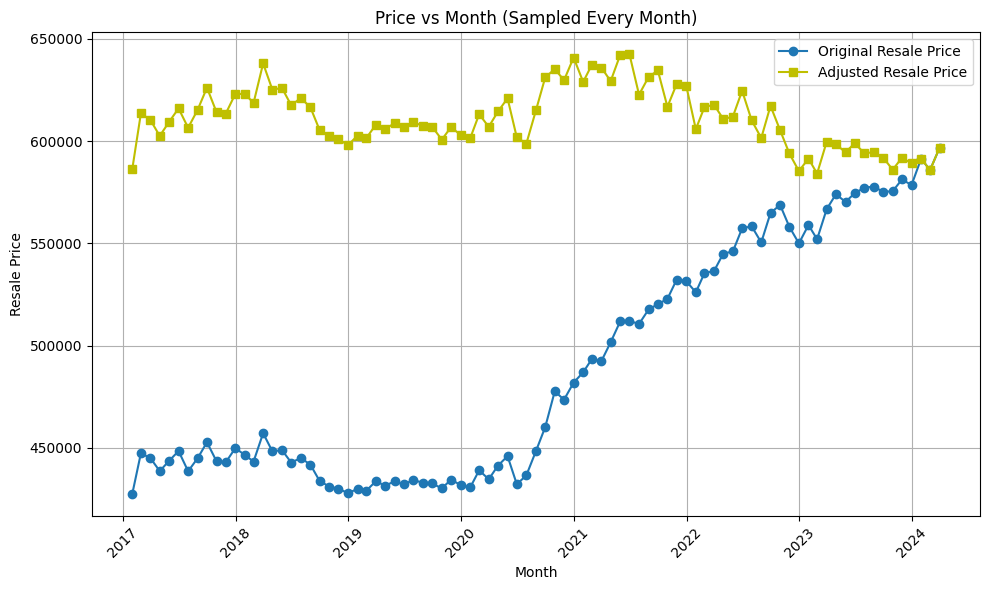

In [5]:
import pandas as pd
import data_config as cfg

df_raw = pd.read_csv('./data/SGHDB2017-2024.csv')
cfg.save_dataset_info(df_raw, fname='dataset_info.csv')

df = cfg.adjust_resale_price(df_raw, cut_off_date='2024-04-01')
cfg.visualize_adjusted_price(df[['month', 'resale_price', 'adjusted_price']].copy(), fname='adjusted_price.png')

df_clean = cfg.preprocess_data(df)
print(df_raw.shape, df.shape, df_clean.shape)
df_clean.to_csv('./data/SGHDB2017-2024_clean.csv', index=False)

Install Required Libraries: 
Ensure you have the necessary libraries installed. You can install them using pip if they are not already installed.
```sgh 
pip install tensorflow pandas scikit-learn
```

### Step 1: 
The project starts by importing the pandas library and loading a cleaned CSV file named {SGHDB2017-2024_clean.csv} into a Pandas DataFrame $df$. Then, the {adjusted_price} column, which represents the housing prices to be predicted, is extracted and stored in the variable $y$ and the remaining columns, which serve as features for the model, are stored in the variable $X$.

In [6]:
# Step 1: Load the data
import pandas as pd
df = pd.read_csv('./data/SGHDB2017-2024_clean.csv')
y = df['adjusted_price'].values   # Target
X = df.drop(columns = 'adjusted_price')  # Features

### Step 2: Prepare the Data:
The dataset is well maintained and prepared by the Singapore government's open data portal. There is no missing data, which simplifies the preprocessing steps. 
Load your dataset and prepare it for training. This includes splitting it into training and testing sets and normalizing the features.

In [7]:
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# Step 2: Prepare the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize continuous features
continuous_columns = ['flat_type', 'floor_area_sqm',  'floor', 'remaining_lease_months']
binary_columns = df.columns.difference(continuous_columns + ['adjusted_price']).tolist()
scaler = StandardScaler()
X_train_continuous = scaler.fit_transform(X_train[continuous_columns])
X_test_continuous = scaler.transform(X_test[continuous_columns])

# Combine scaled continuous features and binary features
X_train = np.hstack([X_train_continuous, X_train[binary_columns].values])
X_test = np.hstack([X_test_continuous, X_test[binary_columns].values])

### Step 3: 
This step defines a function create_regression_model that constructs a feedforward neural network model for regression using TensorFlow's Keras API. 

In [8]:
import tensorflow as tf

def create_initial_regression_model(input_shape, params={}):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(shape=input_shape),    
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    return model


In [9]:
def create_improved_regression_model(input_shape, params={}):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(shape=input_shape),    
        tf.keras.layers.Dense(64, activation='relu'),  # more neurons
        tf.keras.layers.Dense(32, activation='relu'),  # added layer
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

### Step 4: 
The model is trained using the training data  (\(X_{\text{train}}\) and \(y_{\text{train}}\)). The training process runs for 10 epochs (def: \ref{def:epoch}) with a batch size of 32. 

In [10]:
# Step 4: Create and train the initial model
import time
model_initial = create_initial_regression_model(input_shape=[X_train.shape[1]])
start_time = time.time()
history_initial = model_initial.fit(X_train, y_train, epochs=10, batch_size=32, 
                    validation_data=(X_test, y_test), verbose=0)
initial_train_time = time.time() - start_time
print(f"Initial model training time: {initial_train_time:.2f} seconds")

Initial model training time: 113.46 seconds


In [11]:
# Train Improved Model
model_improved = create_improved_regression_model(input_shape=[X_train.shape[1]])
start_time = time.time()
history_improved = model_improved.fit(X_train, y_train, epochs=10, batch_size=32, 
                                      validation_data=(X_test, y_test), verbose=0)
improved_train_time = time.time() - start_time
print(f"Improved model training time: {improved_train_time:.2f} seconds")

Improved model training time: 122.51 seconds


In [12]:
# Khin Hpone seeing th total parameters and layer in model
# Show model summary to see total params
print("Initial Model Summary:")
model_initial.summary()

# Print number of layers
print(f"Number of layers in model: {len(model_initial.layers)}")

# Khin Hpone seeing th total parameters and layer in model
# Show model summary to see total params
print("Improved Model Summary:")
model_improved.summary()

# Print number of layers
print(f"Number of layers in model: {len(model_improved.layers)}")

Initial Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,629 (25.90 KB)

 Trainable params: 2,209 (8.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,420 (17.27 KB)

Number of layers in model: 3
Improved Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,861 (69.77 KB)

 Trainable params: 5,953 (23.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,908 (46.52 KB)

Number of layers in model: 4


### Step 5:
In the last step, the model is evaluated using various performance metrics and saves the evaluation results to a CSV file.

In [13]:
# Step 4: Evaluate the initial model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score

df_results = pd.DataFrame(columns=['Train', 'Test'])

y_pred = model_initial.predict(X_train)
df_results.loc['Root Mean Squared Error', 'Train'] = np.sqrt(mean_squared_error(y_train, y_pred))
df_results.loc['Mean Absolute Error', 'Train'] = mean_absolute_error(y_train, y_pred)
df_results.loc['Mean Absolute Percentage Error', 'Train'] = mean_absolute_percentage_error(y_train, y_pred)*100
df_results.loc['R2 score', 'Train'] = r2_score(y_train, y_pred)

y_pred = model_initial.predict(X_test)
df_results.loc['Root Mean Squared Error', 'Test'] = np.sqrt(mean_squared_error(y_test, y_pred))
df_results.loc['Mean Absolute Error', 'Test'] = mean_absolute_error(y_test, y_pred)
df_results.loc['Mean Absolute Percentage Error', 'Test'] = mean_absolute_percentage_error(y_test, y_pred)*100
df_results.loc['R2 score', 'Test'] = r2_score(y_test, y_pred)

df_results = df_results.astype('Float64').round(2)
df_results.to_csv('./data/model_evaluation.csv')

print(df_results)

3843/3843 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
                                   Train      Test
Root Mean Squared Error         88344.21  88140.54
Mean Absolute Error             66692.28  66502.38
Mean Absolute Percentage Error     11.17     11.16
R2 score                            0.81      0.81


In [14]:
# Step 4: Evaluate the improved model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score

df_results = pd.DataFrame(columns=['Train', 'Test'])

y_pred = model_improved.predict(X_train)
df_results.loc['Root Mean Squared Error', 'Train'] = np.sqrt(mean_squared_error(y_train, y_pred))
df_results.loc['Mean Absolute Error', 'Train'] = mean_absolute_error(y_train, y_pred)
df_results.loc['Mean Absolute Percentage Error', 'Train'] = mean_absolute_percentage_error(y_train, y_pred)*100
df_results.loc['R2 score', 'Train'] = r2_score(y_train, y_pred)

y_pred = model_improved.predict(X_test)
df_results.loc['Root Mean Squared Error', 'Test'] = np.sqrt(mean_squared_error(y_test, y_pred))
df_results.loc['Mean Absolute Error', 'Test'] = mean_absolute_error(y_test, y_pred)
df_results.loc['Mean Absolute Percentage Error', 'Test'] = mean_absolute_percentage_error(y_test, y_pred)*100
df_results.loc['R2 score', 'Test'] = r2_score(y_test, y_pred)

df_results = df_results.astype('Float64').round(2)
df_results.to_csv('./data/model_evaluation.csv')

print(df_results)

3843/3843 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
                                   Train      Test
Root Mean Squared Error         63733.52   63566.5
Mean Absolute Error             46195.35  46109.85
Mean Absolute Percentage Error       7.5       7.5
R2 score                             0.9       0.9


In [ ]:
# Function to evaluate model
def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    results = {
        'RMSE Train': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'RMSE Test': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'R2 Train': r2_score(y_train, y_pred_train),
        'R2 Test': r2_score(y_test, y_pred_test)
    }
    return results

# Evaluate both models
results_initial = evaluate_model(model_initial, X_train, y_train, X_test, y_test)
results_improved = evaluate_model(model_improved, X_train, y_train, X_test, y_test)

# Create dataframe to compare
df_comparison = pd.DataFrame({
    'Initial Model': results_initial,
    'Improved Model': results_improved
}).T

df_comparison['Training Time (s)'] = [initial_train_time, improved_train_time]
df_comparison = df_comparison.round(2)

df_comparison.to_csv('./data/model_comparison.csv')

#Khin Hpone

3843/3843 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
3843/3843 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 918us/step


,RMSE Train,RMSE Test,R2 Train,R2 Test,Training Time (s)
Initial Model,88344.21,88140.54,0.81,0.81,113.46
Improved Model,63733.52,63566.50,0.90,0.90,122.51


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


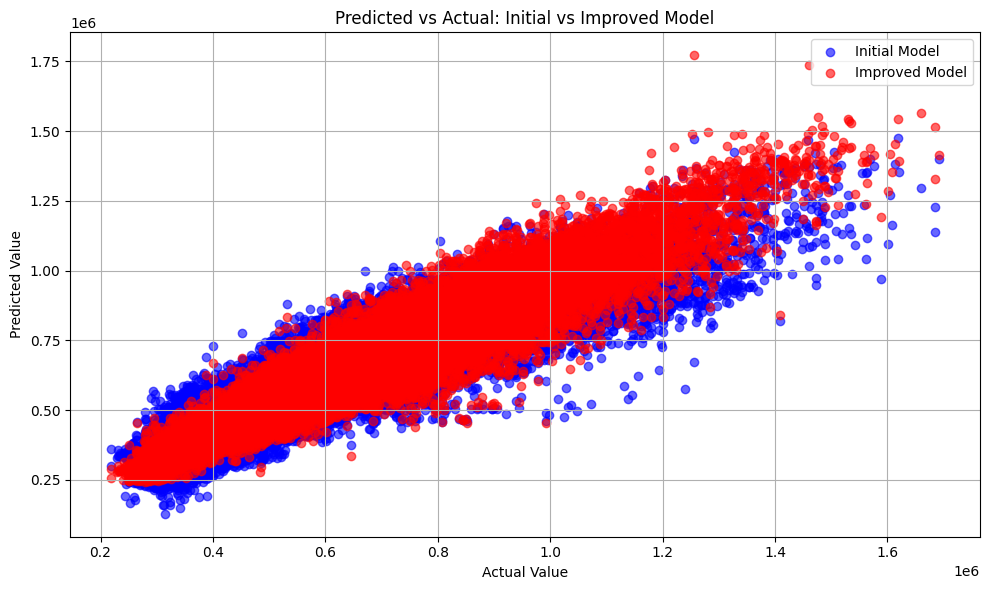

In [32]:
# Predictions
import data_config as cfg
import importlib
import data_config as cfg
importlib.reload(cfg)

y_pred_initial_test = model_initial.predict(X_test)
y_pred_improved_test = model_improved.predict(X_test)

cfg.plot_predictions_comparison(y_test, y_pred_initial_test, y_pred_improved_test, fname='model_prediction_comparison.png')


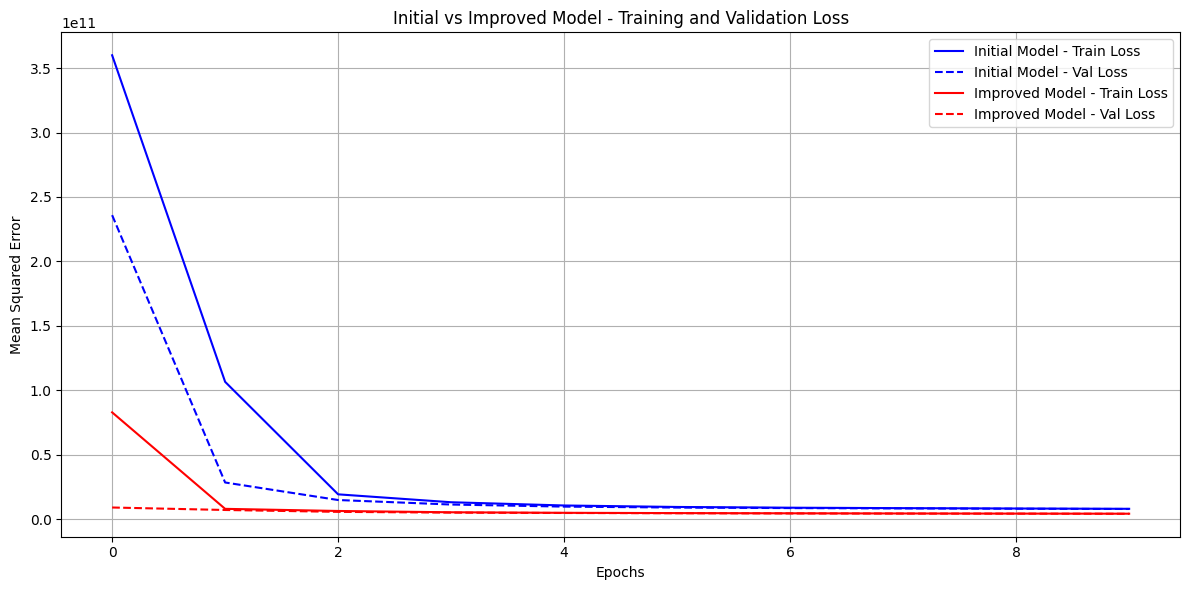

In [ ]:
import data_config as cfg
import importlib     #importing needed to reconncect to the data_config module again and again
import data_config as cfg
importlib.reload(cfg)
# Plot training & validation loss for both models
cfg.plot_loss_comparison(history_initial, history_improved, fname='model_loss_comparison.png')